In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 5)

In [2]:
%matplotlib inline

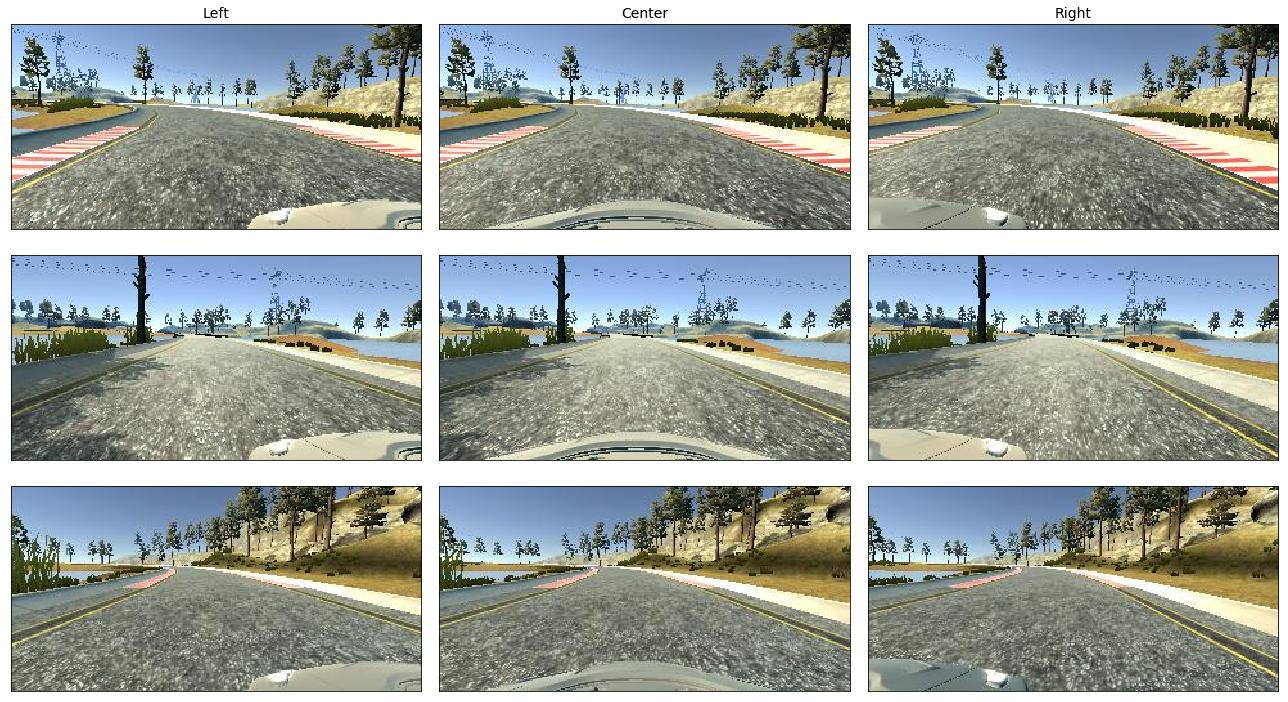

In [17]:
train_data_dir = os.path.join('train_data', '03')
csv_path = os.path.join(train_data_dir, 'driving_log.csv')

columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'break', 'speed']
df = pd.read_csv(csv_path, header=None, names=columns)

num_sample = 3
df_sub = df.sample(num_sample).reset_index()

fig, axes = plt.subplots(num_sample, 3, figsize=(18, 10))
for i, row in df_sub.iterrows():
    for j, col in enumerate(['left', 'center', 'right']):
        img_path = row[col]
        img = cv2.imread(img_path)[:, :, ::-1]
        axes[i][j].imshow(img)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        if i == 0: axes[i][j].set_title(col.capitalize(), fontsize=14)
fig.tight_layout()
plt.savefig(os.path.join('figures', 'samples.jpg'))

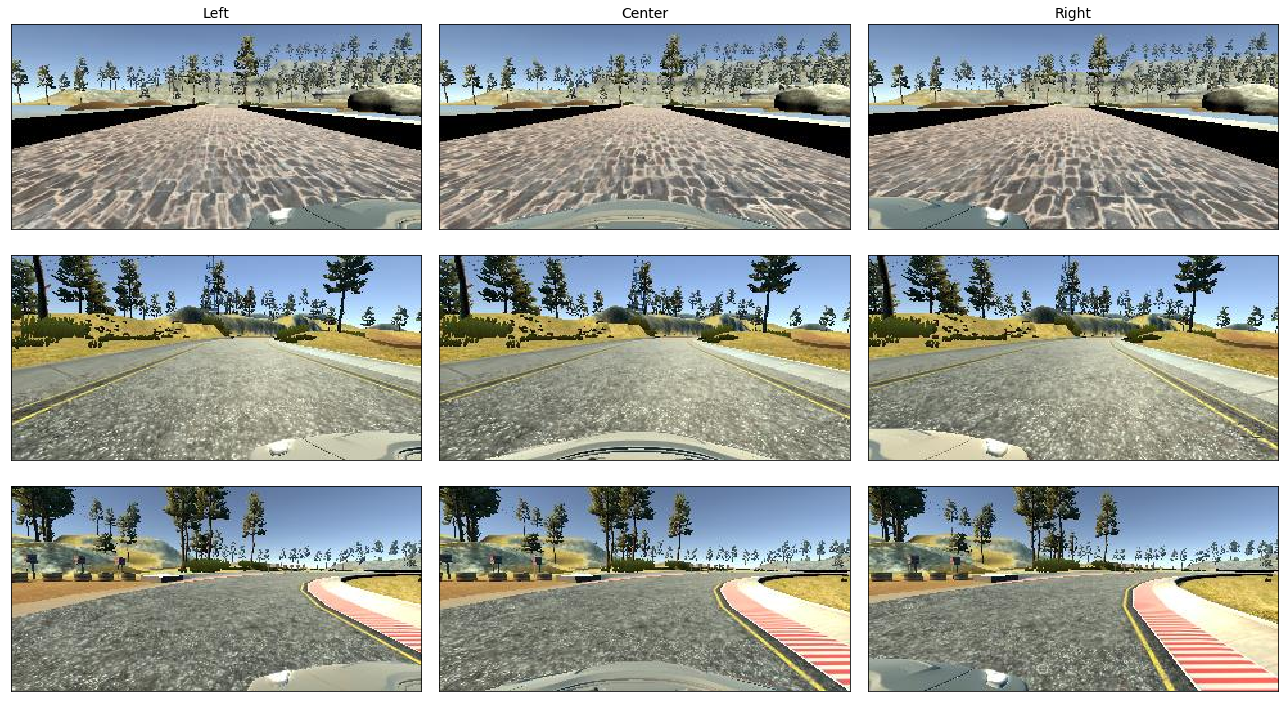

In [18]:
train_data_dir = os.path.join('train_data', '04_reverse')
csv_path = os.path.join(train_data_dir, 'driving_log.csv')

columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'break', 'speed']
df = pd.read_csv(csv_path, header=None, names=columns)

num_sample = 3
df_sub = df.sample(num_sample).reset_index()

fig, axes = plt.subplots(num_sample, 3, figsize=(18, 10))
for i, row in df_sub.iterrows():
    for j, col in enumerate(['left', 'center', 'right']):
        img_path = row[col]
        img = cv2.imread(img_path)[:, :, ::-1]
        axes[i][j].imshow(img)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        if i == 0: axes[i][j].set_title(col.capitalize(), fontsize=14)
fig.tight_layout()
plt.savefig(os.path.join('figures', 'samples_reverse.jpg'))

In [39]:
def load_data(data_dirs):
    img_paths, angles = [], []
    for data_dir in data_dirs:
        csv_path = os.path.join(data_dir, 'driving_log.csv')
        columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'break', 'speed']
        df = pd.read_csv(csv_path, header=None, names=columns)
        df_straight = df[df['steering_angle'] == 0]
        df_turn = df[df['steering_angle'] != 0]
        print(df_straight.shape, df_turn.shape)
        df_straight_sub = df_straight.sample(df_turn.shape[0] * 3)
        df_train = pd.concat([df_turn, df_straight_sub])
        for i, row in df_train.iterrows():
            img_paths += row[['center', 'left', 'right']].tolist()
            angle = row['steering_angle']
            angles += [angle, angle + 0.2, angle - 0.2]
    
    return img_paths, angles

def bgr2yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    

def crop(img):
    return img[60:-25, :, :]


def resize(img):
    return cv2.resize(img, (160, 70))


def random_flip(img, angle):
    if np.random.rand() > 0.5:
        img = img[:, ::-1, :]
        angle = -angle
    return img, angle


def random_shift(img, angle):
    h, w = img.shape[:2]
    tx = np.random.uniform(-10, 10)
    ty = np.random.uniform(-10, 10)
    angle += tx * 0.002
    affine_matrix = np.float32([[1, 0, tx],
                                [0, 1, ty]])
    img = cv2.warpAffine(img, affine_matrix, (w, h))
    return img, angle


def augment(img, angle):
    img, angle = random_flip(img, angle)
    img, angle = random_shift(img, angle)
    return img, angle


def batch_generator(img_paths, angles, batch_size, is_augment=True):
    assert len(img_paths) == len(angles), 'img_paths and angles must be the same length'
    n = len(img_paths)
    batch_idx = 0
    
    while 1:
        if batch_idx == 0: idx_array = np.random.permutation(n)
        current_idx = (batch_idx * batch_size) % n
        img_batch = []
        angle_batch = []
        for idx in idx_array[current_idx:current_idx + batch_size]:
            img_path = img_paths[idx]
            angle = angles[idx]
            img = cv2.imread(img_path)[:, :, ::-1]
            img = crop(img)
            if is_augment: img, angle = augment(img, angle)
            img_batch.append(img)
            angle_batch.append(angle)
            
        if n > current_idx + batch_size:
            batch_idx += 1
        else:
            batch_idx = 0
            idx_array = np.random.permutation(n)
        
        yield np.array(img_batch), np.array(angle_batch)

In [40]:
train_data_dirs = ['train_data/03', 'train_data/04_reverse']
img_paths, angles = load_data(train_data_dirs)
X_train, X_valid, y_train, y_valid = train_test_split(img_paths, angles, train_size=0.8)
print('Number of training data: {}'.format(len(X_train)))
print('Number of validation data: {}'.format(len(X_valid)))

(3442, 7) (909, 7)
(2926, 7) (701, 7)
Number of training data: 15456
Number of validation data: 3864


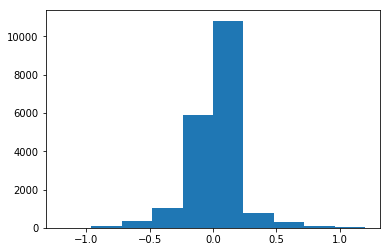

In [41]:
plt.hist(angles);

# Preprocessed

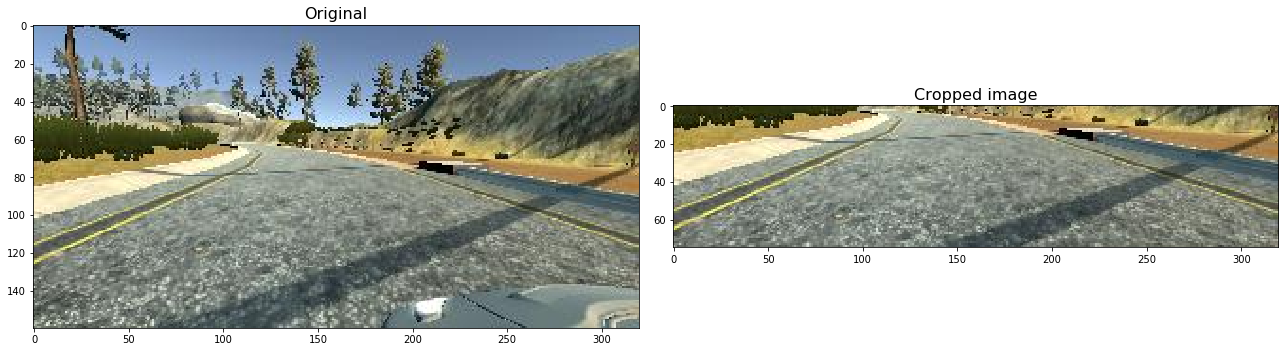

In [52]:
img_path = img_paths[100]
img = cv2.imread(img_path)[:, :, ::-1]
img_crop = crop(img)
img_resize = resize(img)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].imshow(img)
axes[0].set_title('Original', fontsize=16)
axes[1].imshow(img_crop)
axes[1].set_title('Cropped image', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join('figures', 'preprocessed.jpg'))

## How augmentation works

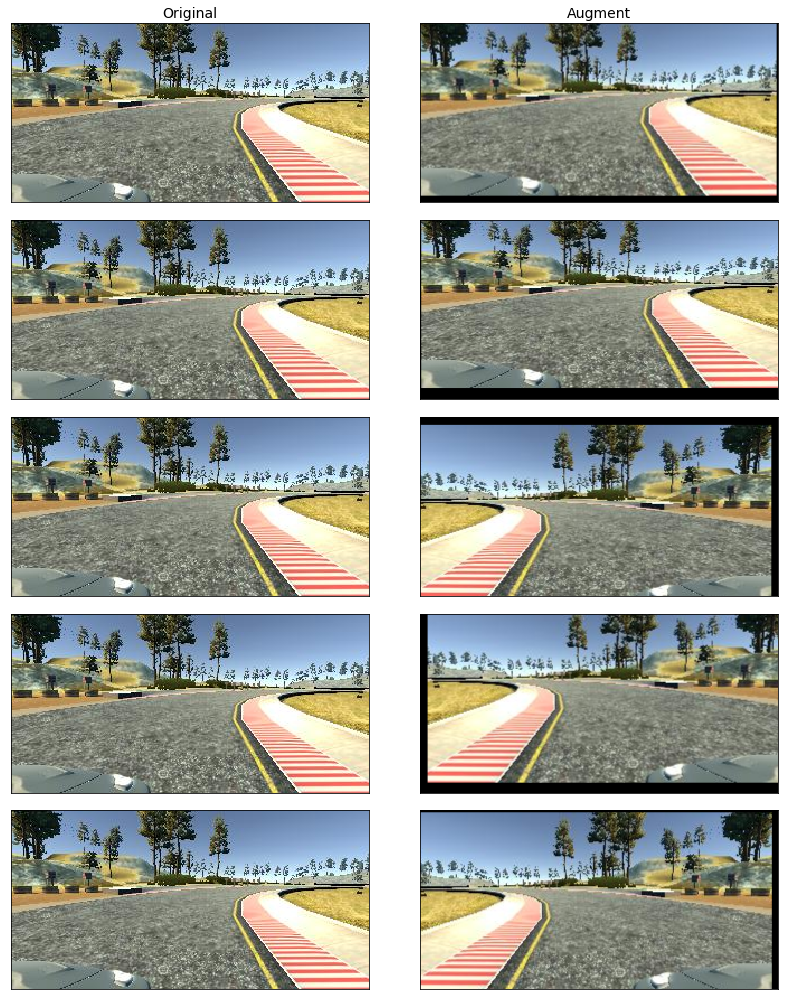

In [22]:
num_sample = 5
fig, axes = plt.subplots(num_sample, 2, figsize=(12, 14))
for i, img_path in enumerate(np.random.choice(img_paths, 5)):
    for j, label in enumerate(['Original', 'Augment']):
        img_path = row[col]
        img = cv2.imread(img_path)[:, :, ::-1]
        if j == 1: img, _ = augment(img, 0)
        axes[i][j].imshow(img)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        if i == 0: axes[i][j].set_title(label, fontsize=14)
fig.tight_layout()
plt.savefig(os.path.join('figures', 'augmented_images.jpg'))

https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef9

In [23]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Lambda, Input, Cropping2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [24]:
img_shape = (70, 320, 3)
batch_size = 33
epochs = 15
steps_per_epoch = np.ceil(len(X_train) / batch_size)
valid_steps = np.ceil(len(X_valid) / batch_size)
lr = 0.0001

In [10]:
# build model
base_model = applications.VGG19(weights = 'imagenet', include_top=False, input_shape=(img_shape))
base_model.summary()
for layer in base_model.layers:
    layer.trainable = False


inputs = Input(img_shape)
x = Lambda(lambda x: x / 127.5 - 1, output_shape=img_shape)(inputs)
x = Cropping2D(cropping=((70, 25), (0, 0)))(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(128, activation='elu')(x)
x = Dense(64, activation='elu')(x)
x = Dense(32, activation='elu')(x)
pred = Dense(1)(x)
model = Model(input=inputs, output=pred)
    
adam = optimizers.Adam(lr)
model.compile(loss = 'mse', optimizer=adam)
model.summary()

# train model
model.fit_generator(batch_generator(X_train, y_train, batch_size),
                    steps_per_epoch,
                    epochs,
                    validation_data=batch_generator(X_valid, y_valid, batch_size, is_augment=False),
                    validation_steps=valid_steps,
                    verbose=1)
# # save model
model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70, 320, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 70, 320, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 70, 320, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 35, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 35, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 35, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 17, 80, 128)       0         
__________